# Arsenal - Squad Profile Analysis

This is an analytics exercise to look at distribution of minutes across the different age-groups in the squad. 

Arsenal are entering a rebuilding phase and have a promising crop of academy players and other young talents. 

I'm interested to see if the squad is trending younger and if we are giving our youth talent enough game-time to properly develop them.

I did a similar [exercise](https://github.com/vpn75/squad_age_profile/blob/master/squad_age_profile_analysis.md) using R and I wanted to try and recreate it in Python. I will also be using a newer data-viz library, [Altair](https://altair-viz.github.io/getting_started/overview.html) that I've been interested in learning.

In [273]:
#Package imports
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import altair as alt
import re
import json

We'll start by scraping the squad data for Arsenal in the Premier League this season.

In [201]:
url = 'http://us.soccerway.com/teams/england/arsenal-fc/660/squad/'

html = requests.get(url).text

soup = BeautifulSoup(html, 'html.parser')

data = []

table = soup.find_all('table')[0]
trs = table.find_all('tr')[1:] #Skip header row

for tr in trs:
    player = [c.text.strip() for c in tr.find_all('td')[2:8]]
    player.pop(1) #Remove 2nd list element containing nationality flag
    data.append(player)


Now that we have our scraped data, we'll convert it to a Pandas dataframe.

In [202]:
df = pd.DataFrame(data)
df.columns = ['player', 'age', 'position', 'minutes', 'appearances']

We'll need to convert some of the columns to numeric for our analysis.

In [203]:
#Convert cols to numeric
cols = ['age','minutes','appearances']
df[cols] = df[cols].apply(pd.to_numeric)

#Confirm dtype conversion
df.dtypes

player         object
age             int64
position       object
minutes         int64
appearances     int64
dtype: object

Let's filter out any players that did not feature in the league.

In [204]:
df = df[df.appearances > 0]

We'll do some more data-cleaning by converting the **position** column to a categorical value and re-classify them to make it more readable.

Also noticed that Maitland-Niles was classified as a Midfielder for some reason when he had made most of his appearances at RB so changed his position to Defense.

We'll also update name of defender, Sokratis to improve display in our final viz.

In [205]:
df.loc[df.player == 'A. Maitland-Niles', ['position']] = 'D'
df['position'] = df['position'].map({'A':'Forward','G':'Goalie','D':'Defense', 'M':'Midfield'}).astype('category')
df['player'] = df['player'].str.replace('S. Papastathopoulos','Sokratis')

df.head()

,player,age,position,minutes,appearances
0,B. Leno,27,Goalie,2340,26
3,Bellerín,24,Defense,533,6
4,K. Tierney,22,Defense,299,5
5,Sokratis,31,Defense,1607,18
6,R. Holding,24,Defense,86,2
7,S. Mustafi,27,Defense,530,7
8,C. Chambers,25,Defense,1103,14
9,David Luiz,32,Defense,2006,23
10,S. Kolašinac,26,Defense,1089,16
15,Dani Ceballos,23,Midfield,745,12


Next, we'll add a new column that calculates the percentage of total league-minutes played per player.

In [206]:
gp = df.appearances.max()

df['mp_pct'] = round(df['minutes']/(gp*90), 2)
df.head()

,player,age,position,minutes,appearances,mp_pct
0,B. Leno,27,Goalie,2340,26,1.00
3,Bellerín,24,Defense,533,6,0.23
4,K. Tierney,22,Defense,299,5,0.13
5,Sokratis,31,Defense,1607,18,0.69
6,R. Holding,24,Defense,86,2,0.04


I wasn't happy with the way the player names looked. 

Some had first initial but others like Bellerin, just had their lastname. 

Let's split out the name so we can separate the last name from the first initial.

In [207]:
tdf = df.reset_index(drop=True).copy()

tdf[['fname','lname']] = tdf.player.str.split(expand=True)

tdf.head()

,player,age,position,minutes,appearances,mp_pct,fname,lname
0,B. Leno,27,Goalie,2340,26,1.00,B.,Leno
1,Bellerín,24,Defense,533,6,0.23,Bellerín,None
2,K. Tierney,22,Defense,299,5,0.13,K.,Tierney
3,Sokratis,31,Defense,1607,18,0.69,Sokratis,None
4,R. Holding,24,Defense,86,2,0.04,R.,Holding


OK, looking better but we can see we have an issue players that did not have first initials. They have NA values for lname now so let's clean them up.

For the players with nulls in lname, we'll just replace with the value from **player**.

In [208]:
idx = tdf[tdf.lname.isna()].index.values

for val in idx:
    tdf.at[val,'lname'] = tdf.at[val, 'player']
    
tdf.drop('fname', axis=1, inplace=True)
tdf

,player,age,position,minutes,appearances,mp_pct,lname
0,B. Leno,27,Goalie,2340,26,1.00,Leno
1,Bellerín,24,Defense,533,6,0.23,Bellerín
2,K. Tierney,22,Defense,299,5,0.13,Tierney
3,Sokratis,31,Defense,1607,18,0.69,Sokratis
4,R. Holding,24,Defense,86,2,0.04,Holding
5,S. Mustafi,27,Defense,530,7,0.23,Mustafi
6,C. Chambers,25,Defense,1103,14,0.47,Chambers
7,David Luiz,32,Defense,2006,23,0.86,Luiz
8,S. Kolašinac,26,Defense,1089,16,0.47,Kolašinac
9,Dani Ceballos,23,Midfield,745,12,0.32,Ceballos


## Building the viz

OK, now the names look good and we're ready to build our squad-profile viz.

In the past, I have been reluctant to use Python for data visualization because I was not a fan of matplotlib.

Coming more from the Rstats world, I missed the declarative syntax of the awesome ggplot library.

So, I was really happy when I came across the Altair package which is just a Python wrapper for [Vega-lite](https://vega.github.io/vega-lite/)

It has an elegant, declarative syntax that utilizes the "grammar of graphics" style that I loved from ggplot2.

I also find the default visual output to be more aesthetically pleasing than matplotlib.

## Viz components

Our squad profile viz will consist of 3 components:

 * Scatter plot of players with Age on **x-axis** and % played of max league minutes on **y-axis**
 * Player name labels 
 * Shaded region indicating peak-age bracket
 
We'll start by creating our base-layer that creates our scatter plot. 

I added some customization to the **y-axis** to display in percent-format. 

I also tweaked the range of the axis-ticks to improve display.

In [209]:
base = alt.Chart(tdf).encode(
    alt.X('age:Q',
          scale=alt.Scale(domain=[16, 34]),
          axis=alt.Axis(values=[16,18,20,22,24,26,28,30,32,34,36]),
          title='Player Age'
         ),
    alt.Y('mp_pct:Q',
        axis=alt.Axis(format='%', 
        title='% played of max league minutes',
        values=[.1,.2,.3,.4,.5,.6,.7,.8,.9,1]),
        scale=alt.Scale(domain=[0, 1.01]),
        )
)

Next, we'll add the marks that will create our scatter-plot. I've added a color legend based on player position using the categories we created earlier. 

In [210]:
points = base.mark_circle(size=120).encode(
    color=alt.Color(
        'position',
        title='Position', 
        scale=alt.Scale(domain=(['Goalie','Defense','Midfield','Forward']))
    )
)

Next, comes the player-name labels. I used the lastname rather than the playername with first initial for cleaner display.

In [211]:
text = base.mark_text(
    align='left',
    baseline='middle',
    dx=10, # Nudges text to right so it doesn't appear on top of the bar
    font='Menlo'
).encode(
    text='lname'
)

This layer will create the shaded rectangular region that will indicate the peak-age group. 

One thing I discovered was that I couldn't use age-values from the **x-axis** in the encoding specification. 

Rather, I had to pick the values based on the overall width of the final viz that you will see specified further down. 

This was a bit counter-intuitive and worked differently from ggplot.

I defined the peak-age range as 24-30 years old.

In [212]:
rect = alt.Chart(tdf).mark_rect(fill='green').encode(
    x=alt.value(266),
    x2=alt.value(468),
    opacity=alt.value(0.01)
)

Finally, we'll bring all the layers together and add our final customizations including font and font-size.

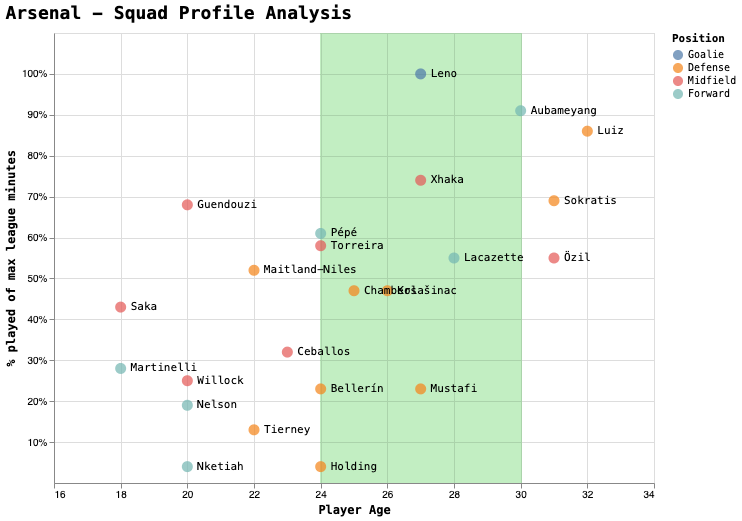

In [277]:
(rect+points+text).properties(
    width=600, 
    height=450, 
    title='Arsenal - Squad Profile Analysis'
).configure_title(
        fontSize=18, 
        orient='top', 
        anchor='start', 
        offset=10, 
        font='Menlo'
).configure_axis(
        titleFont='Menlo',
        titleFontSize=12
).configure_legend(
        titleFont='Menlo',
        labelFont='Menlo'
).display(renderer='svg')

## Thoughts

As my first foray into Altair, I was pretty happy with how the final viz turned out. 

I wish Altair supported something similar to the **ggrepl** package in R that could more intelligently space out the labels to avoid overlap.

Another source of frustration was the inability to add a subtitle. 

Apparently Vega-lite was patched recently to support this, but I could not get it to work in my environment for some reason in spite of confirming I had the latest versions of Altair/Vega


## Bonus analysis

Let's continue our analysis on the dataset.

We can look at the average age by position.

In [214]:
tdf.groupby('position').age.mean()

position
Defense     25.888889
Forward     23.333333
Goalie      27.000000
Midfield    23.285714
Name: age, dtype: float64

Let's create another viz that shows distribution of minutes by player.

We'll create a sorted bar-chart. 

As a bonus, we'll take advantage of Altair's interactive capabilities by adding a tooltip that appears as you hover over the player bar to display additional information.

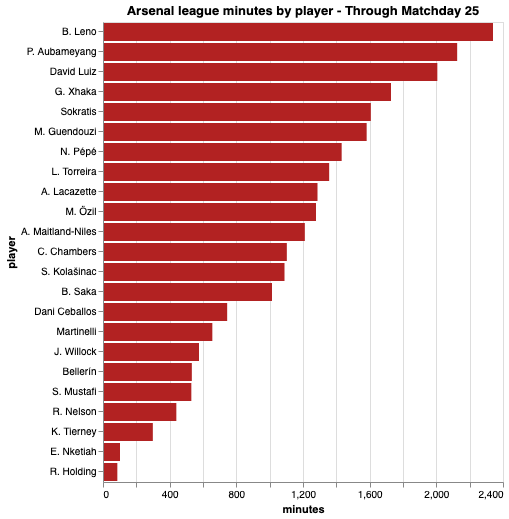

In [276]:

chart = alt.Chart(df).mark_bar(color='firebrick').encode(
    x='minutes:Q',
    y=alt.Y(
        'player',
        sort=alt.SortField(field="minutes", order='descending')
    ),
    tooltip = ['player', 'age', 'appearances', 'minutes']
)

chart.properties(
    title={
        'text':'Arsenal league minutes by player - Through Matchday 25'
    }
).display(renderer='svg')


It could also be interesting to see the distribution of minutes across different age-groups in the squad.

We'll drop the goalie position since only Leno has featured for Arsenal in the league this season.

In [254]:
df2 = df.copy()

def age_group(df):
    
    if df.age >= 16 and df.age < 24:
        df['age_group'] = 'Youth'
    elif df.age >= 24 and df.age <= 30:
        df['age_group'] = 'Prime'
    else: 
        df['age_group'] = 'Senior'
    return df

#df2.assign(age_group=age_group(df))
df2 = df2.apply(age_group, axis=1)
df2.head()

,player,age,position,minutes,appearances,mp_pct,age_group
0,B. Leno,27,Goalie,2340,26,1.00,Prime
3,Bellerín,24,Defense,533,6,0.23,Prime
4,K. Tierney,22,Defense,299,5,0.13,Youth
5,Sokratis,31,Defense,1607,18,0.69,Senior
6,R. Holding,24,Defense,86,2,0.04,Prime


We can visualize this information using a stacked bar-chart.

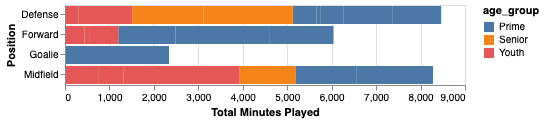

In [256]:
df2.drop

alt.Chart(df2).mark_bar().encode(
    x=alt.X('minutes:Q', title='Total Minutes Played'),
    y=alt.Y('position:N', title='Position'),
    color='age_group:N'
).display(renderer='svg')
